In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from summer2 import CompartmentalModel
from summer2.parameters import Parameter, DerivedOutput

In [2]:
def build_sis_model(
    config: dict,
) -> CompartmentalModel:
    
    # Model characteristics
    compartments = (
        "susceptible",
        "infectious",
    )
    analysis_times = (
        config["start_time"], 
        config["end_time"],
    )
    model = CompartmentalModel(
        times=analysis_times,
        compartments=compartments,
        infectious_compartments=["infectious"],
    )
    model.set_initial_population(
        distribution=
        {
            "susceptible": config["population"] - config["seed"], 
            "infectious": config["seed"],
        }
    )
    
    # Transitions
    model.add_infection_frequency_flow(
        name="infection", 
        contact_rate=Parameter("contact_rate"),
        source="susceptible", 
        dest="infectious",
    )
    model.add_transition_flow(
        name="recovery", 
        fractional_rate=Parameter("recovery"),
        source="infectious", 
        dest="susceptible",
    )
    
    # Outputs
    model.request_output_for_flow(
        "incidence",
        "infection",
        save_results=False,
    )
    model.request_function_output(
        "incidence_rate",
        func=DerivedOutput("incidence") * 1e5 * 30,  # Per 100,000 per month
    )
    
    return model

In [3]:
model_config = {
    "start_time": 0.,
    "end_time": 50. * 365.,
    "population": 1.,
    "seed": 1e-5,
}

parameters = {
    "contact_rate": 1.5 / 60.,
    "recovery": 1. / 60.,
}

In [4]:
sis_model = build_sis_model(model_config)
sis_model.run(parameters=parameters, solver="euler")
sis_outputs = sis_model.get_derived_outputs_df()
sis_outputs.index = sis_outputs.index / 365.

#### Panel a)

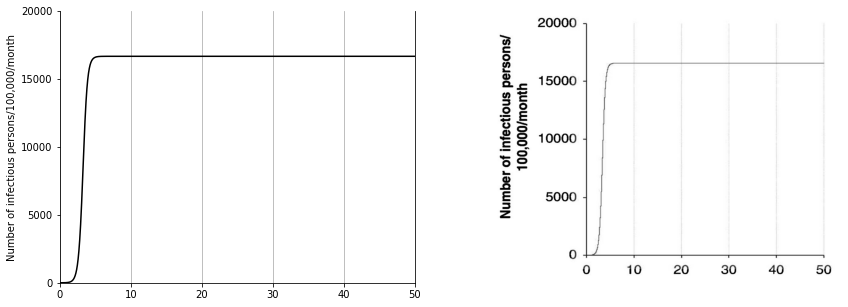

In [5]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))

left_ax.plot(
    sis_outputs.index,
    sis_outputs["incidence_rate"],
    color="k",
)
left_ax.set_xlim(0., 50.)
left_ax.grid(axis="x")
left_ax.set_ylim(0., 2e4)
left_ax.set_yticks(range(0, 25000, 5000))
left_ax.set_ylabel("Number of infectious persons/100,000/month")
left_ax.spines.top.set_visible(False)

image = plt.imread("./figures/fig_4_31a.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");

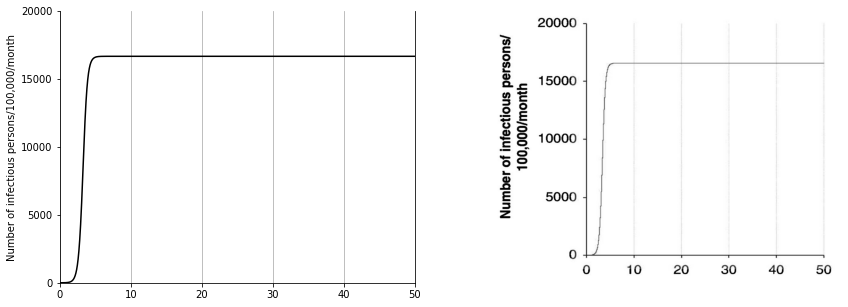

In [6]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))

left_ax.plot(
    sis_outputs.index,
    sis_outputs["incidence_rate"],
    color="k",
)
left_ax.set_xlim(0., 50.)
left_ax.grid(axis="x")
left_ax.set_ylim(0., 2e4)
left_ax.set_yticks(range(0, 25000, 5000))
left_ax.set_ylabel("Number of infectious persons/100,000/month")
left_ax.spines.top.set_visible(False)

image = plt.imread("./figures/fig_4_31a.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");

In [7]:
def build_sirs_model(
    config: dict,
) -> CompartmentalModel:

    # Model characteristics
    compartments = (
        "susceptible",
        "infectious",
        "recovered",
    )
    analysis_times = (
        config["start_time"], 
        config["end_time"],
    )
    model = CompartmentalModel(
        times=analysis_times,
        compartments=compartments,
        infectious_compartments=["infectious"],
    )
    model.set_initial_population(
        distribution=
        {
            "susceptible": config["population"] - config["seed"], 
            "infectious": config["seed"],
        }
    )
    
    # Transitions
    model.add_infection_frequency_flow(
        name="infection", 
        contact_rate=Parameter("contact_rate"),
        source="susceptible", 
        dest="infectious",
    )
    model.add_transition_flow(
        name="recovery", 
        fractional_rate=Parameter("recovery"),
        source="infectious", 
        dest="recovered",
    )
    model.add_transition_flow(
        name="waning",
        fractional_rate=Parameter("waning"),
        source="recovered",
        dest="susceptible",
    )
    
    # Outputs
    model.request_output_for_flow(
        "incidence",
        "infection",
    )
    model.request_function_output(
        "incidence_rate",
        func=DerivedOutput("incidence") * 1e5 * 30,
    )    
    return model

In [8]:
wane_rates = (8, 10, 12)
sirs_outputs = pd.DataFrame(columns=wane_rates)
sirs_model = build_sirs_model(model_config)
for wane_rate in wane_rates:
    parameters.update(
        {
            "waning": (1. / wane_rate + 1. / 30.) / 365.,  # Not clear whether 1/30 should be added
        }
    )
    sirs_model.run(parameters=parameters, solver="euler")
    sirs_outputs[wane_rate] = sirs_model.get_derived_outputs_df()["incidence_rate"]
sirs_outputs.index = sirs_outputs.index / 365.

#### Panel b)

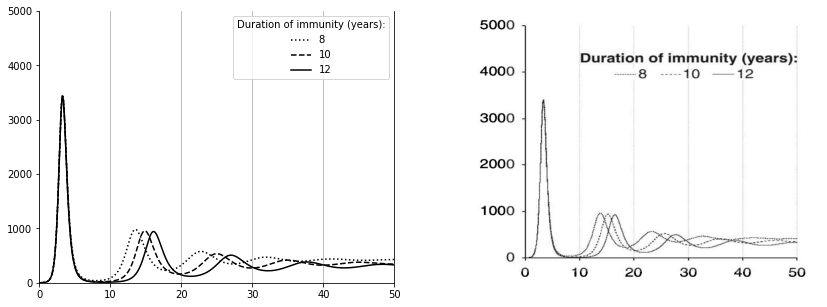

In [25]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))

linestyles = (":", "--", "-")

for i_rate, wane_rate in enumerate(wane_rates):
    left_ax.plot(
        sirs_outputs.index,
        sirs_outputs[wane_rate],
        color="k",
        linestyle=linestyles[i_rate],
        label=wane_rate,
    )
left_ax.set_xlim(0., 50.)
left_ax.grid(axis="x")
left_ax.set_ylim(0., 5e3)
left_ax.legend(title="Duration of immunity (years):")
left_ax.spines.top.set_visible(False)

image = plt.imread("./figures/fig_4_31b.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");